# Using the Serendip Experiential Engine API

This notebook demonstrates how to programmatically interact with the Serendip Experiential Engine API for tourism review analysis. The API provides two main endpoints:

1. `/predict` - For multi-label classification of tourism reviews
2. `/explain` - For generating explainable AI visualizations using SHAP

## Setup

First, let's import the necessary libraries:

In [17]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from IPython.display import HTML, display
import plotly.express as px
import plotly.graph_objects as go

# Define the API base URL - change this to your deployment URL
API_BASE_URL = "http://localhost:8000"  # When running locally with Docker

## Sample Tourism Reviews

Let's define a few example tourism reviews from Sri Lanka to test our API:

In [18]:
sample_reviews = [
    """Our stay at the eco-lodge in Sinharaja Rainforest was transformative. The resort used solar power, 
    rainwater harvesting, and served locally-grown organic food. We participated in a community 
    reforestation project and learned about sustainable tourism practices from local guides.""",
    
    """I spent a week at a wellness retreat in the hills of Kandy combining yoga, meditation, and 
    traditional Ayurvedic treatments. The early morning meditation sessions overlooking the misty 
    mountains were incredibly peaceful, and the personalized Ayurvedic consultations helped me 
    create a balanced health routine I've maintained since returning home.""",
    
    """The cooking class in Galle was the highlight of our trip! We visited the local market with the 
    chef to select fresh spices and ingredients before learning to prepare traditional Sri Lankan 
    curry, hoppers, and sambols. Understanding the cultural significance of each dish and tasting 
    the complex flavors we created ourselves was an unforgettable experience.""",
    
    """We hired a local guide who took us hiking through remote villages in the Knuckles Mountain Range 
    where we stayed with families in homestays. No tourists, no beaten paths - just authentic 
    connections with locals who showed us hidden waterfalls and taught us traditional farming methods. 
    This off-grid adventure was physically challenging but incredibly rewarding."""
]

# For display purposes, let's create shortened versions
sample_reviews_short = [
    "Eco-lodge in Sinharaja Rainforest with sustainable practices and community projects",
    "Wellness retreat in Kandy with yoga, meditation and Ayurvedic treatments",
    "Cooking class in Galle with market visit and traditional Sri Lankan cuisine",
    "Off-grid hiking in Knuckles Mountain Range with homestays and hidden waterfalls"
]

## API Health Check

First, let's verify the API is running by checking the root endpoint:

In [19]:
try:
    response = requests.get(f"{API_BASE_URL}/")
    if response.status_code == 200:
        print(f"✅ API is running: {response.json()}")
    else:
        print(f"❌ API returned status code {response.status_code}")
except Exception as e:
    print(f"❌ Error connecting to API: {e}")
    print("\nMake sure the Docker containers are running with `docker compose up` or check your API_BASE_URL.")
    print("If running the notebook outside the Docker network, you might need to use http://localhost:8000 instead.")

✅ API is running: {'status': 'active', 'model': 'j2damax/serendip-travel-classifier'}


## Using the Predict Endpoint

Let's create a function to call the `/predict` endpoint and classify our sample reviews:

In [20]:
def get_predictions(review_text):
    """
    Call the /predict endpoint to classify a review text
    
    Parameters:
        review_text (str): The tourism review text to analyze
        
    Returns:
        list: List of dictionaries with label and score values
    """
    url = f"{API_BASE_URL}/predict"
    payload = {"review_text": review_text}
    
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()  # Raise exception for 4XX/5XX responses
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling predict endpoint: {e}")
        return []

In [21]:
# Let's test our function on the first review
predictions = get_predictions(sample_reviews[0])
print(f"Predictions for Review 1 (Eco-Lodge):")
for p in predictions:
    print(f"{p['label']}: {p['score']:.4f}")

Predictions for Review 1 (Eco-Lodge):
Regenerative & Eco-Tourism: 0.0000
Integrated Wellness: 0.0000
Immersive Culinary: 0.0000
Off-the-Beaten-Path Adventure: 0.0000


## Processing Multiple Reviews

Now let's process all of our sample reviews and visualize the results:

In [22]:
# Process all reviews
all_predictions = []
for i, review in enumerate(sample_reviews):
    print(f"Processing review {i+1}...")
    pred = get_predictions(review)
    all_predictions.append(pred)
    # Small delay to avoid overwhelming the API
    time.sleep(0.5)
    
print("Done processing all reviews!")

Processing review 1...
Processing review 2...
Processing review 2...
Processing review 3...
Processing review 3...
Processing review 4...
Processing review 4...
Done processing all reviews!
Done processing all reviews!


In [23]:
# Convert predictions to a DataFrame for easier visualization
def create_predictions_df(predictions_list, review_labels):
    """Convert the list of predictions to a DataFrame"""
    data = []
    for i, predictions in enumerate(predictions_list):
        for pred in predictions:
            data.append({
                "Review": review_labels[i],
                "Dimension": pred["label"],
                "Score": pred["score"]
            })
    return pd.DataFrame(data)

# Create DataFrame
pred_df = create_predictions_df(all_predictions, sample_reviews_short)
pred_df.head(10)

,Review,Dimension,Score
0,Eco-lodge in Sinharaja Rainforest with sustain...,Regenerative & Eco-Tourism,0.0
1,Eco-lodge in Sinharaja Rainforest with sustain...,Integrated Wellness,0.0
2,Eco-lodge in Sinharaja Rainforest with sustain...,Immersive Culinary,0.0
3,Eco-lodge in Sinharaja Rainforest with sustain...,Off-the-Beaten-Path Adventure,0.0
4,"Wellness retreat in Kandy with yoga, meditatio...",Regenerative & Eco-Tourism,0.0
5,"Wellness retreat in Kandy with yoga, meditatio...",Integrated Wellness,0.0
6,"Wellness retreat in Kandy with yoga, meditatio...",Immersive Culinary,0.0
7,"Wellness retreat in Kandy with yoga, meditatio...",Off-the-Beaten-Path Adventure,0.0
8,Cooking class in Galle with market visit and t...,Regenerative & Eco-Tourism,0.0
9,Cooking class in Galle with market visit and t...,Integrated Wellness,0.0


### Visualizing the Predictions

Let's create some visualizations to better understand the predictions:

In [9]:
# 1. Bar Chart with Plotly
fig = px.bar(pred_df, x="Dimension", y="Score", color="Review", barmode="group",
             title="Experiential Dimensions by Review",
             labels={"Score": "Confidence Score", "Dimension": "Experiential Dimension"},
             height=500)

# Update layout
fig.update_layout(
    xaxis={'categoryorder': 'total descending'},
    legend_title_text='Review',
    font=dict(size=12)
)

fig.show()

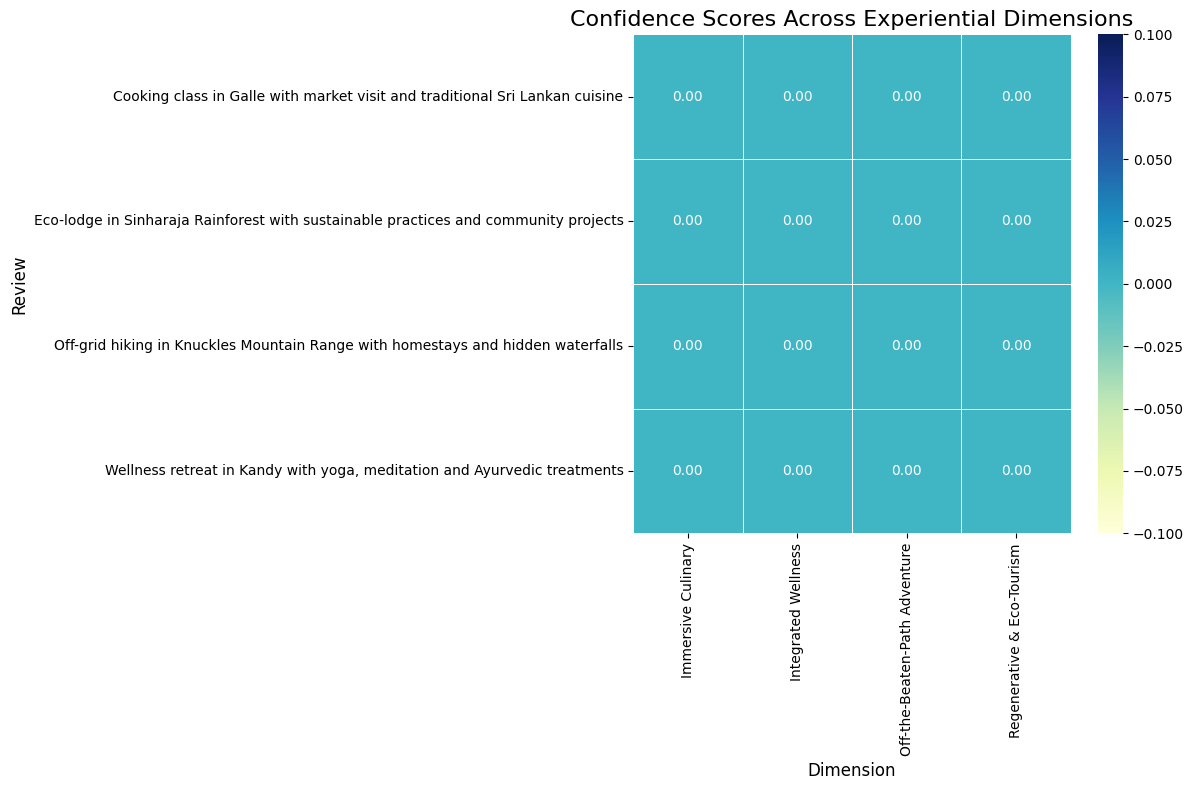

In [10]:
# 2. Heatmap showing all dimensions for each review
pivot_df = pred_df.pivot(index="Review", columns="Dimension", values="Score")

# Create a heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Confidence Scores Across Experiential Dimensions", fontsize=16)
plt.ylabel("Review", fontsize=12)
plt.xlabel("Dimension", fontsize=12)
plt.tight_layout()
plt.show()

## Using the Explain Endpoint

Now let's explore the explainability features by calling the `/explain` endpoint. This endpoint provides SHAP values to explain model predictions.

In [11]:
def get_explanation(review_text, top_n_words=5):
    """
    Call the /explain endpoint to get SHAP explanations for a review
    
    Parameters:
        review_text (str): The tourism review text to analyze
        top_n_words (int): Number of top influential words to return
        
    Returns:
        dict: Dictionary with HTML visualization and top words
    """
    url = f"{API_BASE_URL}/explain"
    payload = {
        "review_text": review_text,
        "top_n_words": top_n_words
    }
    
    try:
        response = requests.post(url, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error calling explain endpoint: {e}")
        return {"html": "", "top_words": {}}

In [12]:
# Let's get an explanation for our first review (eco-lodge)
explanation = get_explanation(sample_reviews[0], top_n_words=8)

# Display the SHAP visualization
if explanation and "html" in explanation:
    print("SHAP Force Plot Visualization:")
    display(HTML(explanation["html"]))
else:
    print("Failed to get explanation or no HTML content returned")

Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
SHAP Force Plot Visualization:


### Visualizing Top Influential Words

Let's examine the top words that influenced the model's prediction for each experiential dimension:

In [13]:
# Check if we have top words data
if "top_words" in explanation:
    # Create a dataframe for visualization
    top_words_data = []
    
    for dimension, words in explanation["top_words"].items():
        for word_info in words:
            top_words_data.append({
                "Dimension": dimension,
                "Word": word_info["word"],
                "Value": word_info["value"],
                "Impact": "Positive" if word_info["is_positive"] else "Negative"
            })
    
    top_words_df = pd.DataFrame(top_words_data)
    
    # Display the dataframe
    print("Top influential words for each dimension:")
    display(top_words_df)
    
    # Create a horizontal bar chart for top words
    fig = px.bar(
        top_words_df, 
        x="Value", 
        y="Word", 
        color="Impact",
        facet_col="Dimension",
        facet_col_wrap=2,  # Two columns in the facet grid
        height=500,
        width=800,
        color_discrete_map={"Positive": "#198754", "Negative": "#dc3545"},
        labels={"Value": "SHAP Value (Impact)", "Word": ""},
        title="Top Words Influencing Model Predictions",
        orientation='h'  # Horizontal bars
    )
    
    fig.update_yaxes(categoryorder='total ascending')
    fig.update_layout(
        font=dict(size=12),
        legend_title_text='Impact Type'
    )
    
    fig.show()
else:
    print("No top words data available in the explanation response.")

Top influential words for each dimension:


""


ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of [] but received: Value

## Analyzing Multiple Reviews

Let's analyze all our reviews to get a comprehensive view:

In [14]:
# Get explanations for all reviews (this may take a while depending on the API speed)
print("Getting explanations for all reviews...")
all_explanations = []

for i, review in enumerate(sample_reviews):
    print(f"Getting explanation for review {i+1}...")
    expl = get_explanation(review, top_n_words=5)
    all_explanations.append(expl)
    # Add a delay to avoid overwhelming the API
    time.sleep(1)
    
print("Done getting all explanations!")

Getting explanations for all reviews...
Getting explanation for review 1...
Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
Getting explanation for review 2...
Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
Getting explanation for review 2...
Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
Getting explanation for review 3...
Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
Getting explanation for review 3...
Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
Getting explanation for review 4...
Error calling explain endpoint: 500 Server Error: Internal Server Error for url: http://localhost:8000/explain
Getting explanation for review 4...
Error calling explain endpoint: 500 Server

In [15]:
# Combine all top words data
all_top_words = []

for i, expl in enumerate(all_explanations):
    if "top_words" in expl:
        for dimension, words in expl["top_words"].items():
            for word_info in words:
                all_top_words.append({
                    "Review": sample_reviews_short[i],
                    "Dimension": dimension,
                    "Word": word_info["word"],
                    "Value": word_info["value"],
                    "Impact": "Positive" if word_info["is_positive"] else "Negative"
                })

# Create a DataFrame
all_words_df = pd.DataFrame(all_top_words)

# Display the first few rows
all_words_df.head(10)

""


In [16]:
# Create a visualization showing the top words for each dimension across reviews
plt.figure(figsize=(14, 10))

# Group by dimension and word, then calculate average impact
dimension_word_impact = all_words_df.groupby(['Dimension', 'Word'])['Value'].mean().reset_index()

# Get top 10 words per dimension by absolute value
top_words_by_dimension = {}
for dimension in dimension_word_impact['Dimension'].unique():
    dimension_data = dimension_word_impact[dimension_word_impact['Dimension'] == dimension].copy()
    dimension_data['AbsValue'] = dimension_data['Value'].abs()
    top_words = dimension_data.nlargest(10, 'AbsValue')
    top_words_by_dimension[dimension] = top_words

# Create a 2x2 grid of subplots for the 4 dimensions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

dimensions = list(top_words_by_dimension.keys())
colors = ['#2C7BB6', '#D7191C']

for i, dimension in enumerate(dimensions):
    if i < len(axes):
        df = top_words_by_dimension[dimension]
        df = df.sort_values('Value')
        
        # Determine color based on positive/negative value
        bar_colors = ['#D7191C' if x < 0 else '#2C7BB6' for x in df['Value']]
        
        # Create horizontal bar chart
        axes[i].barh(df['Word'], df['Value'], color=bar_colors)
        axes[i].set_title(f"Top Influential Words: {dimension}", fontsize=14)
        axes[i].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        axes[i].set_xlabel('Average SHAP Value', fontsize=12)
        
        # Add a color legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='#2C7BB6', label='Positive Impact'),
            Patch(facecolor='#D7191C', label='Negative Impact')
        ]
        axes[i].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

KeyError: 'Dimension'

<Figure size 1400x1000 with 0 Axes>

## Creating a Batch Processing Function

For convenience, let's create a utility function to process multiple reviews at once:

In [ ]:
def batch_process_reviews(reviews, with_explanations=False, top_n_words=5, delay=0.5):
    """
    Process multiple reviews with the API
    
    Parameters:
        reviews (list): List of review texts
        with_explanations (bool): Whether to get explanations (slower)
        top_n_words (int): Number of top words in explanations
        delay (float): Delay between API calls
        
    Returns:
        dict: Results with predictions and optionally explanations
    """
    results = {
        "predictions": [],
        "explanations": [] if with_explanations else None
    }
    
    for i, review in enumerate(reviews):
        print(f"Processing review {i+1}/{len(reviews)}...")
        
        # Get predictions
        pred = get_predictions(review)
        results["predictions"].append(pred)
        
        # Get explanations if requested
        if with_explanations:
            expl = get_explanation(review, top_n_words)
            results["explanations"].append(expl)
        
        # Small delay to avoid overwhelming the API
        time.sleep(delay)
    
    print("Done processing all reviews!")
    return results

In [ ]:
# Example usage
# This is commented out to avoid re-running everything
# We already have the results stored in all_predictions and all_explanations

# Example of how you would use the batch function
"""
new_reviews = [
    "The eco-friendly resort in Ella was amazing. We participated in tree planting and learned about conservation.",
    "Relaxing yoga and meditation retreat with incredible Ayurvedic treatments and healthy local cuisine."
]

results = batch_process_reviews(new_reviews, with_explanations=True)
"""

## Saving Results for Further Analysis

Let's save our predictions and explanations for further analysis:

In [ ]:
# Save the prediction results to CSV
pred_df.to_csv('../data/processed/api_predictions.csv', index=False)

# Save all words data
all_words_df.to_csv('../data/processed/api_explanations_words.csv', index=False)

# Save raw predictions and explanations as JSON
results_for_export = {
    "predictions": all_predictions,
    "explanations": [
        {
            "top_words": e["top_words"] if "top_words" in e else {}
        } for e in all_explanations
    ],
    "review_texts": sample_reviews,
    "review_labels": sample_reviews_short
}

import os
os.makedirs('../data/processed', exist_ok=True)

with open('../data/processed/api_results.json', 'w') as f:
    json.dump(results_for_export, f, indent=2)

print("Results saved to data/processed/ directory!")

## Conclusion

In this notebook, we demonstrated how to:

1. Connect to the Serendip Experiential Engine API
2. Classify tourism reviews using the `/predict` endpoint
3. Generate explainable AI visualizations with the `/explain` endpoint
4. Analyze and visualize the results
5. Save data for further analysis

The API provides a powerful way to analyze tourism reviews and understand their experiential dimensions, with transparent explanations of the model's predictions.